In [2]:
import pandas as pd

# Load datasets
fraud_df   = pd.read_csv("../data/raw/Fraud_Data.csv",
                         parse_dates=['signup_time', 'purchase_time'],
                         dtype={'user_id': 'int64',
                                'device_id': 'string',
                                'source': 'string',
                                'browser': 'string',
                                'sex': 'category',    # saves memory
                                'age': 'Int64',       # allows NA
                                'ip_address': 'float'})   # will coerce to int later

credit_df  = pd.read_csv("../data/raw/creditcard.csv")
ip_df      = pd.read_csv("../data/raw/IpAddress_to_Country.csv",
                         dtype={'lower_bound_ip_address': 'int64',
                                'upper_bound_ip_address': 'int64',
                                'country': 'string'})


# Check for missing values
print(fraud_df.isnull().sum())
print(ip_df.isnull().sum())
print(credit_df.isnull().sum())


user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64
lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [ ]:
print(fraud_df['age'].isnull().any())  

False


In [4]:
# Impute age with median
# fraud_df['age'].fillna(fraud_df['age'].median(), inplace=True)


# Remove duplicates
ip_df.drop_duplicates(inplace=True)
fraud_df.drop_duplicates(inplace=True)
credit_df.drop_duplicates(inplace=True)

In [5]:
# Convert time columns to datetime
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

# Check data types
print(fraud_df.dtypes)

user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id         string[python]
source            string[python]
browser           string[python]
sex                     category
age                        Int64
ip_address               float64
class                      int64
dtype: object


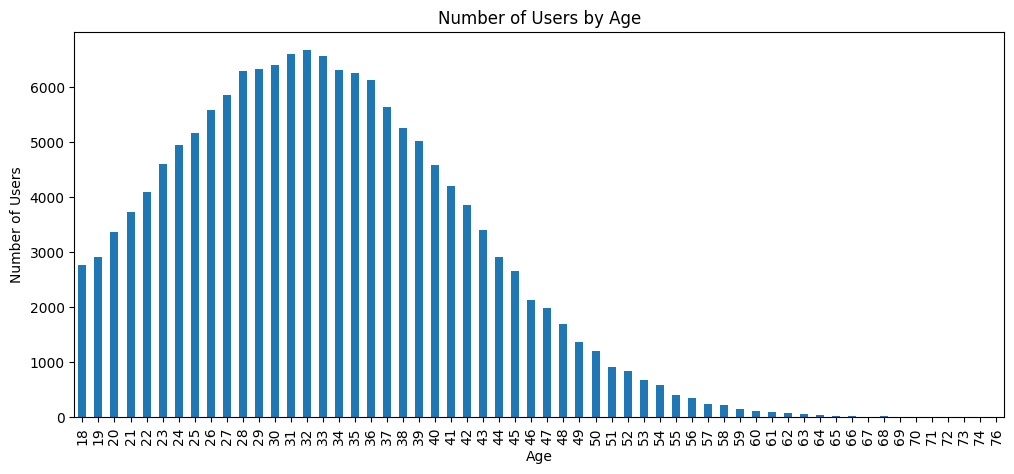

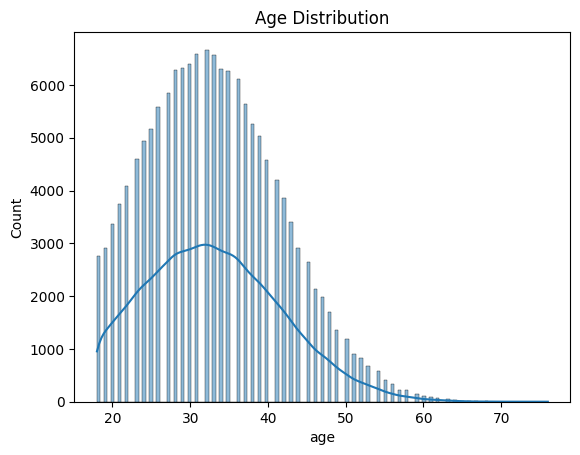

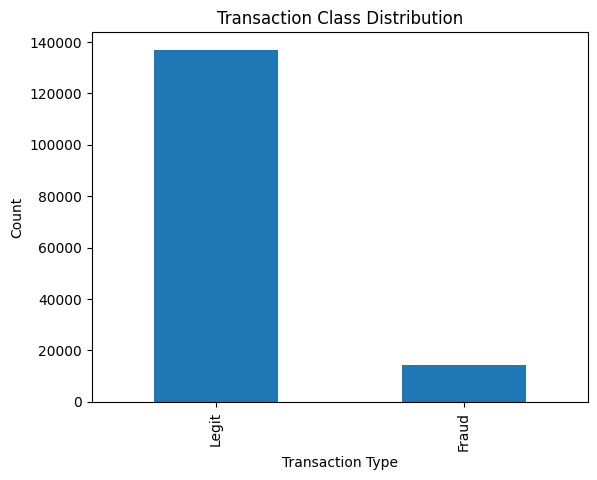

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

age_counts = fraud_df.groupby('age')['user_id'].count()
age_counts.plot(kind='bar', figsize=(12, 5))
plt.title("Number of Users by Age")
plt.xlabel("Age")
plt.ylabel("Number of Users")
plt.show()

sns.histplot(fraud_df['age'], kde=True)
plt.title("Age Distribution")
plt.show()

fraud_df['class'].replace({0: 'Legit', 1: 'Fraud'}).value_counts().plot(kind='bar')
plt.title("Transaction Class Distribution")
plt.ylabel("Count")
plt.xlabel("Transaction Type")
plt.show()


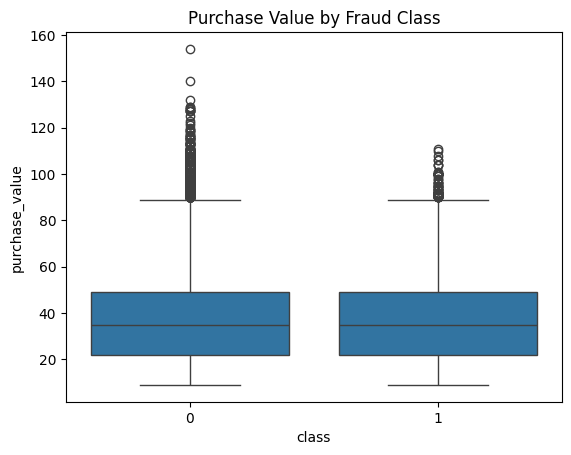

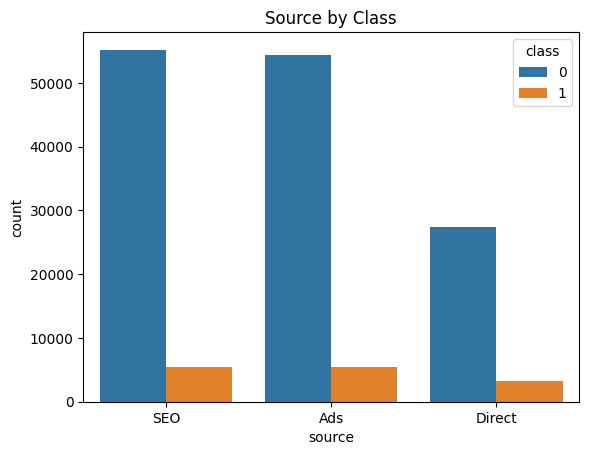

In [ ]:
# Boxplot: Purchase Value by Fraud Class with readable labels
sns.boxplot(
    x=fraud_df['class'].map({0: 'Legit', 1: 'Fraudulent'}),
    y=fraud_df['purchase_value']
)
plt.title("Purchase Value by Fraud Class")
plt.xlabel("Transaction Class")
plt.ylabel("Purchase Value")
plt.show()

# Countplot: Source by Class with readable labels
sns.countplot(
    x='source',
    hue=fraud_df['class'].map({0: 'Legit', 1: 'Fraudulent'}),
    data=fraud_df
)
plt.title("Transaction Source by Class")
plt.xlabel("Source")
plt.ylabel("Count")
plt.legend(title='Class')
plt.show()


# sns.boxplot(x='class', y='purchase_value', data=fraud_df)
# plt.title("Purchase Value by Fraud Class")
# plt.show()

# sns.countplot(x='source', hue='class', data=fraud_df)
# plt.title("Source by Class")
# plt.show()

In [ ]:
import ipaddress

fraud_df['ip_address_int'] = fraud_df['ip_address'].apply(lambda x: int(ipaddress.IPv4Address(x)))

In [ ]:
# Convert IP ranges to int
ip_df['lower_bound_ip_int'] = ip_df['lower_bound_ip_address'].apply(lambda x: int(ipaddress.IPv4Address(x)))
ip_df['upper_bound_ip_int'] = ip_df['upper_bound_ip_address'].apply(lambda x: int(ipaddress.IPv4Address(x)))

# Function to map IP to country
def map_country(ip):
    row = ip_df[(ip_df['lower_bound_ip_int'] <= ip) & (ip_df['upper_bound_ip_int'] >= ip)]
    return row['country'].values[0] if not row.empty else 'Unknown'

fraud_df['country'] = fraud_df['ip_address_int'].apply(map_country)


In [ ]:
# Transactions per user
user_tx_count = fraud_df.groupby('user_id').size().reset_index(name='transaction_count')
fraud_df = fraud_df.merge(user_tx_count, on='user_id', how='left')

In [ ]:
# time based feature
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds() / 3600  # in hours

In [ ]:
# class imbalance 
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Prepare features
X = fraud_df.drop(['class', 'signup_time', 'purchase_time', 'ip_address', 'ip_address_int'], axis=1)
X = pd.get_dummies(X)  # encode categorical
y = fraud_df['class']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Apply SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)


In [ ]:
# scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)